In [ ]:
!pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate
!git clone https://github.com/mkthoma/stable_diffusion.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 68.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 79.7 MB/s eta 0:00:00
Cloning into 'stable_diffusion'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 11 (delta 0), reused 8 (delta 0), pack-reused 0
Receiving objects: 100% (11/11), 17.20 KiB | 429.00 KiB/s, done.


In [ ]:
%pip install -qq -U datasets transformers pyarrow==9.0.0
%pip install -qq --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 31.1 MB/s eta 0:00:00


In [ ]:
from base64 import b64encode

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os
import cv2
import torchvision.transforms as T

torch.manual_seed(1)
logging.set_verbosity_error()

torch_device = "cuda" if torch.cuda.is_available() else "cpu"


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
# Load the autoencoder
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='vae')

# Load tokenizer and text encoder to tokenize and encode the text
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# Unet model for generating latents
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder='unet')

# Noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# Move everything to GPU
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

style_files = ['stable_diffusion/learned_embeddings/arcane-style-jv.bin', 'stable_diffusion/learned_embeddings/birb-style.bin',
                     'stable_diffusion/learned_embeddings/dr-strange.bin', 'stable_diffusion/learned_embeddings/midjourney-style.bin',
                     'stable_diffusion/learned_embeddings/oil_style.bin']

images_without_loss = []
images_with_loss = []

seed_values = [8,16,50,80,128]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 10            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
num_styles = len(style_files)


**Generate Clip embeddings for input text embeddings**

In [ ]:
# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

**Create custom embeddings**

In [ ]:
def get_style_embeddings(style_file):
    style_embed = torch.load(style_file)
    style_name = list(style_embed.keys())[0]
    return style_embed[style_name]

**Define Custom Loss**

In [ ]:
import torch

def vibrance_loss(image):
    # Calculate the standard deviation of color channels
    std_dev = torch.std(image, dim=(2, 3))  # Compute standard deviation over height and width
    # Calculate the mean standard deviation across the batch
    mean_std_dev = torch.mean(std_dev)
    # You can adjust a scale factor to control the strength of vibrance regularization
    scale_factor = 100.0
    # Calculate the vibrance loss
    loss = -scale_factor * mean_std_dev
    return loss

In [ ]:
from torchvision.transforms import ToTensor

def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def additional_guidance(latents, scheduler, noise_pred, t, sigma, custom_loss_fn):
    #### ADDITIONAL GUIDANCE ###
    # Requires grad on the latents
    latents = latents.detach().requires_grad_()

    # Get the predicted x0:
    latents_x0 = latents - sigma * noise_pred
    #print(f"latents: {latents.shape}, noise_pred:{noise_pred.shape}")
    #latents_x0 = scheduler.step(noise_pred, t, latents).pred_original_sample

    # Decode to image space
    denoised_images = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 # range (0, 1)

    # Calculate loss
    loss = custom_loss_fn(denoised_images)

    # Get gradient
    cond_grad = torch.autograd.grad(loss, latents, allow_unused=False)[0]

    # Modify the latents based on this gradient
    latents = latents.detach() - cond_grad * sigma**2
    return latents, loss


def generate_with_embs(text_embeddings, max_length, random_seed, loss_fn = None):
    generator = torch.manual_seed(random_seed)   # Seed generator to create the inital latent noise
    batch_size = 1

    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        if loss_fn is not None:
            if i%2 == 0:
                latents, custom_loss = additional_guidance(latents, scheduler, noise_pred, t, sigma, loss_fn)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

def generate_images(prompt, style_num=None, random_seed=41, custom_loss_fn = None):
    eos_pos = len(prompt.split())+1

    style_token_embedding = None
    if style_num:
        style_token_embedding = get_style_embeddings(style_files[style_num])

    # tokenize
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    max_length = text_input.input_ids.shape[-1]
    input_ids = text_input.input_ids.to(torch_device)

    # get token embeddings
    token_emb_layer = text_encoder.text_model.embeddings.token_embedding
    token_embeddings = token_emb_layer(input_ids)

    # Append style token towards the end of the sentence embeddings
    if style_token_embedding is not None:
        token_embeddings[-1, eos_pos, :] = style_token_embedding

    # combine with pos embs
    pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
    position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
    position_embeddings = pos_emb_layer(position_ids)
    input_embeddings = token_embeddings + position_embeddings

    #  Feed through to get final output embs
    modified_output_embeddings = get_output_embeds(input_embeddings)

    # And generate an image with this:
    generated_image = generate_with_embs(modified_output_embeddings, max_length, random_seed, custom_loss_fn)
    return generated_image

In [ ]:
import matplotlib.pyplot as plt

def display_images_in_rows(images_with_titles, titles):
    num_images = len(images_with_titles)
    rows = 5  # Display 5 rows always
    columns = 1 if num_images == 5 else 2  # Use 1 column if there are 5 images, otherwise 2 columns
    fig, axes = plt.subplots(rows, columns + 1, figsize=(15, 5 * rows))  # Add an extra column for titles

    for r in range(rows):
        # Add the title on the extreme left in the middle of each picture
        axes[r, 0].text(0.5, 0.5, titles[r], ha='center', va='center')
        axes[r, 0].axis('off')

        # Add "Without Loss" label above the first column and "With Loss" label above the second column (if applicable)
        if columns == 2:
            axes[r, 1].set_title("Without Loss", pad=10)
            axes[r, 2].set_title("With Loss", pad=10)

        for c in range(1, columns + 1):
            index = r * columns + c - 1
            if index < num_images:
                image, _ = images_with_titles[index]
                axes[r, c].imshow(image)
                axes[r, c].axis('off')

    return fig
    # plt.show()

In [ ]:
def image_generator(prompt = "dog", loss_function=None):
  images_without_loss = []
  images_with_loss = []

  for i in range(num_styles):
      generated_img = generate_images(prompt,style_num = i,random_seed = seed_values[i],custom_loss_fn = None)
      images_without_loss.append(generated_img)
      if loss_function:
        generated_img = generate_images(prompt,style_num = i,random_seed = seed_values[i],custom_loss_fn = loss_function)
        images_with_loss.append(generated_img)

  generated_sd_images = []
  titles = ["Arcane Style", "Birb Style", "Dr Strange Style", "Midjourney Style", "Oil Style"]

  for i in range(len(titles)):
    generated_sd_images.append((images_without_loss[i], titles[i]))
    if images_with_loss != []:
      generated_sd_images.append((images_with_loss[i], titles[i]))


  return display_images_in_rows(generated_sd_images, titles)

<ipython-input-8-34c62697732e>:60: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

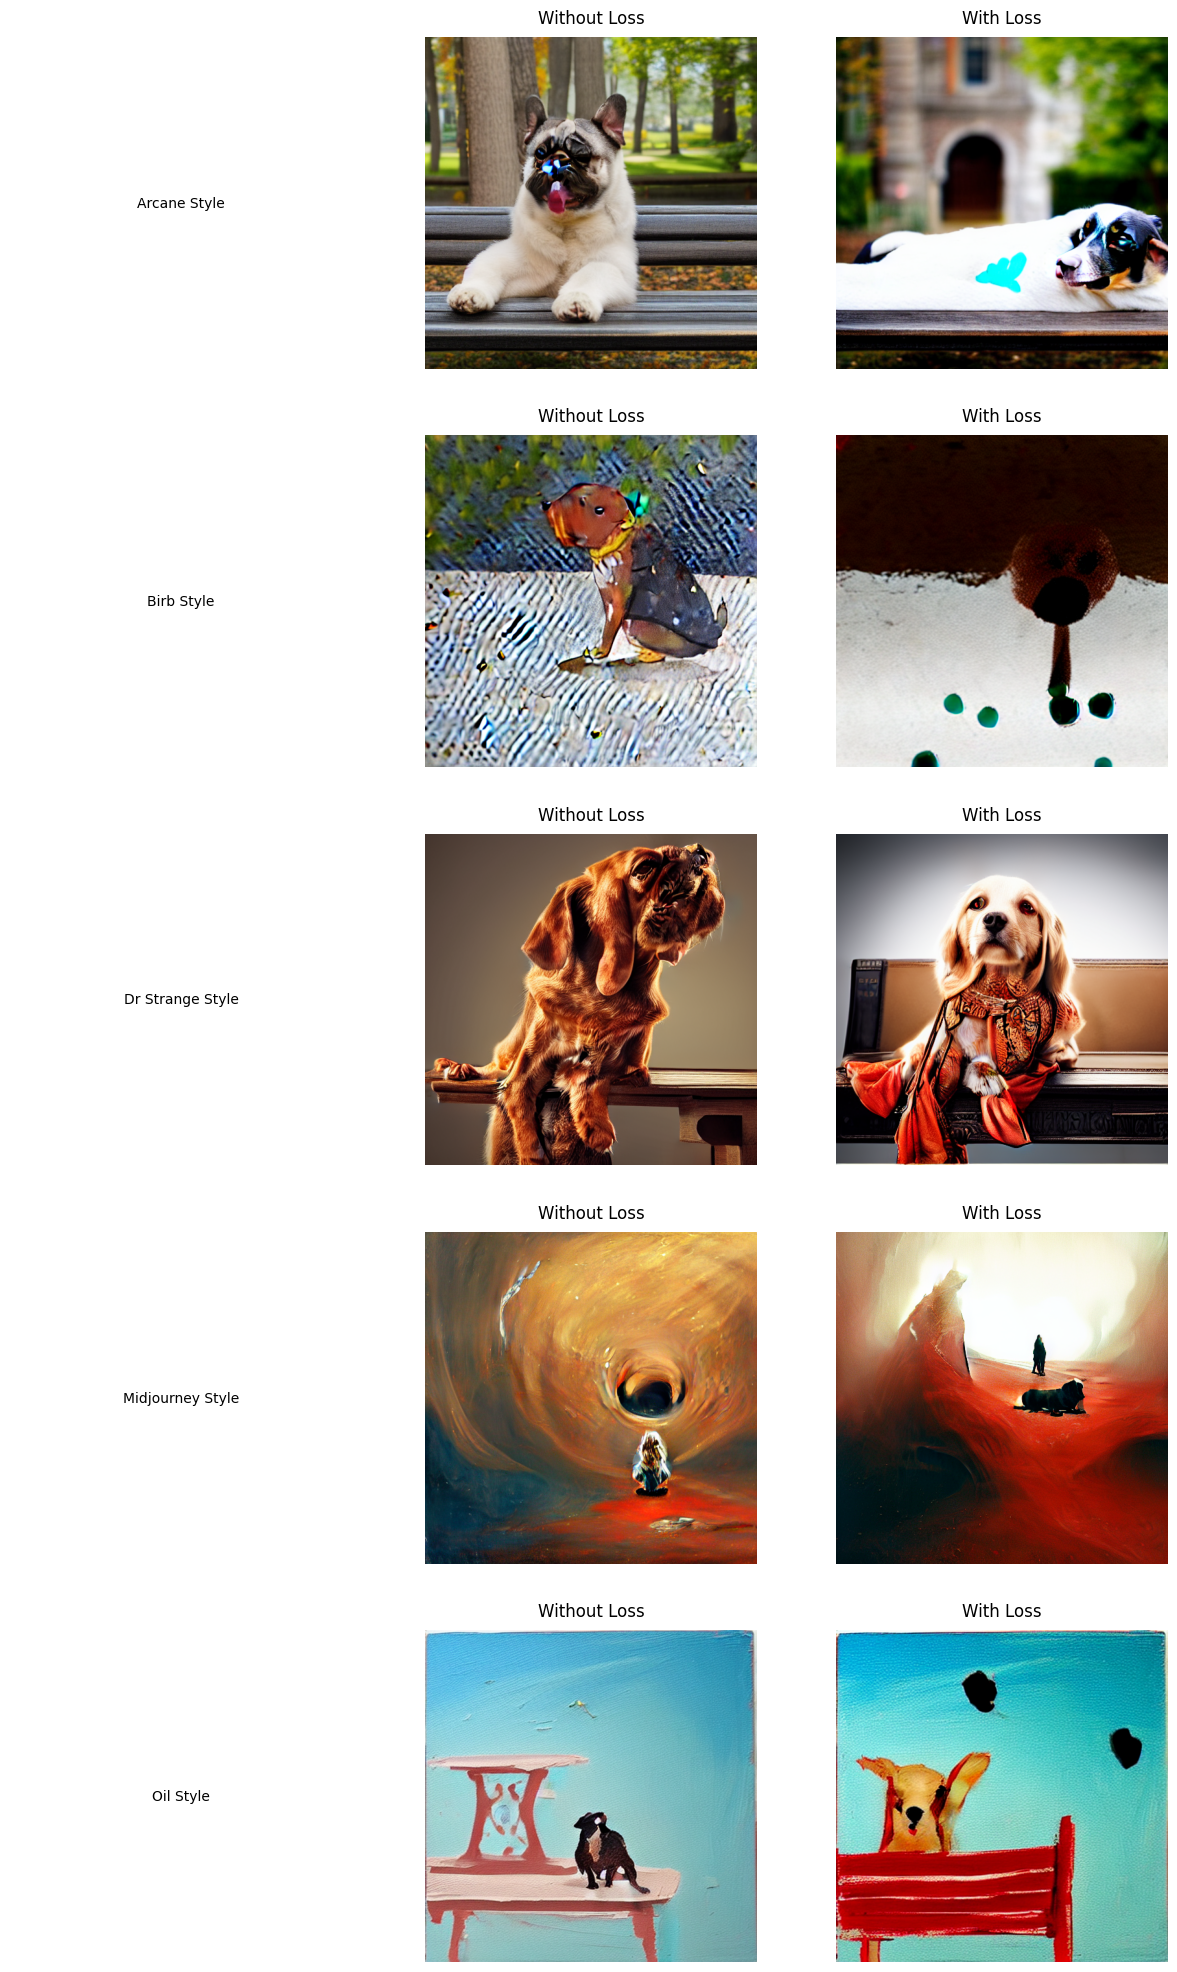

In [ ]:
image_generator(prompt = "dog sitting on a bench", loss_function=vibrance_loss)

<ipython-input-8-34c62697732e>:60: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

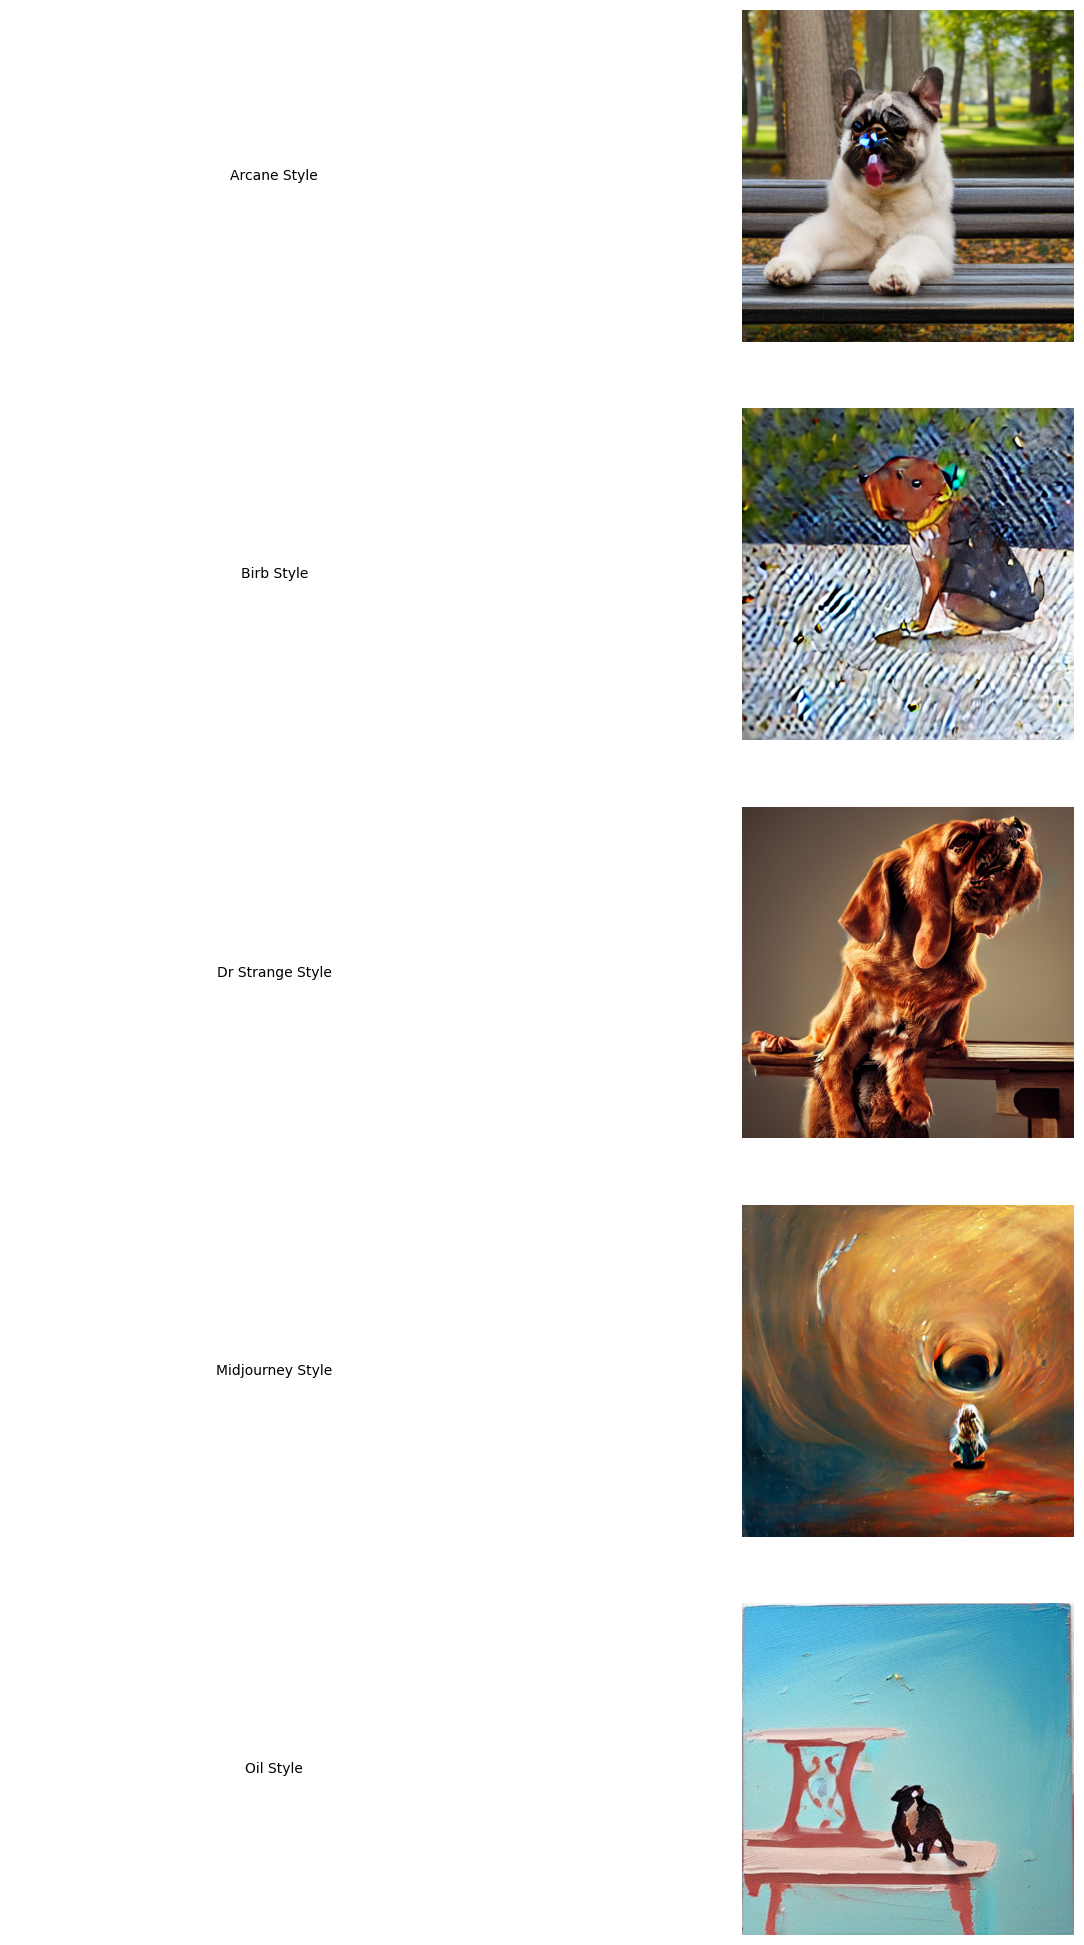

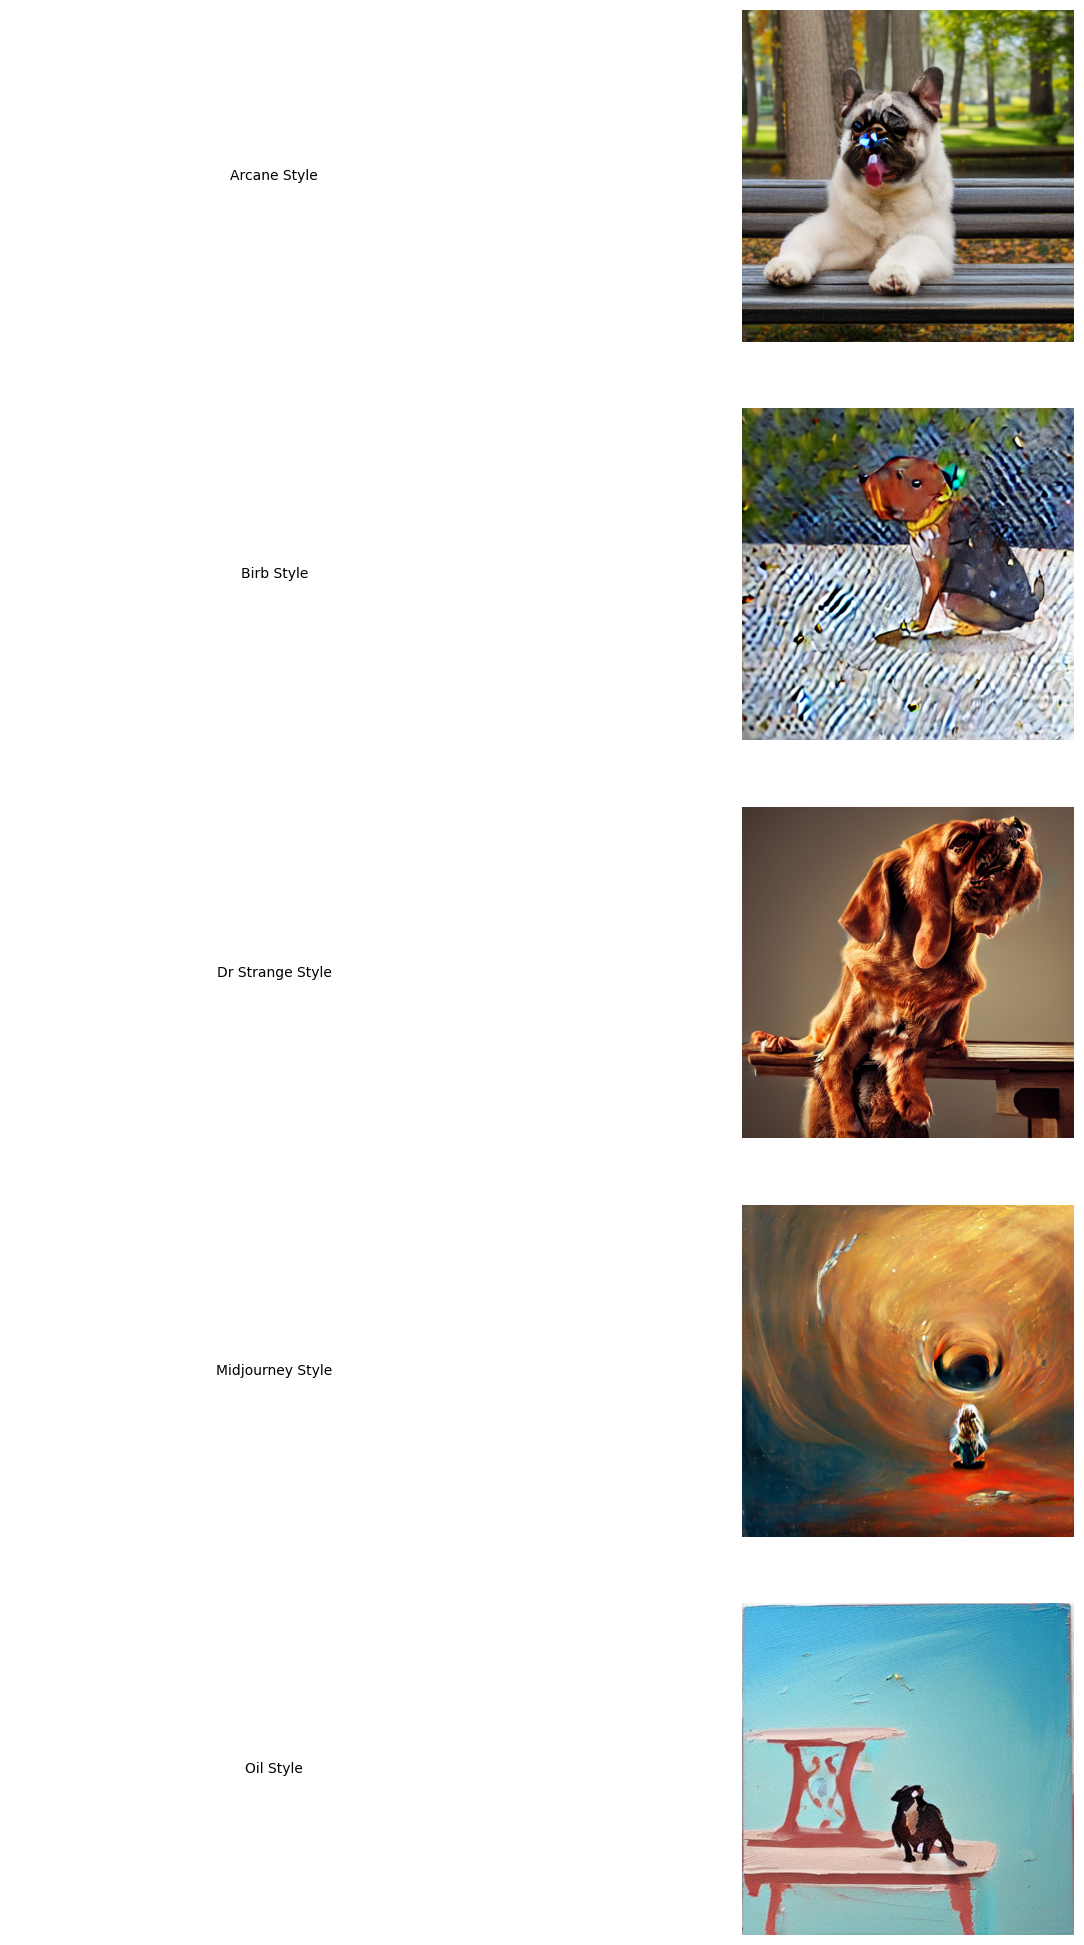

In [ ]:
image_generator(prompt = "dog sitting on a bench")